In [1]:

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os

device = torch.device("cuda:0")
# device = torch.device("cpu")

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    elif model.__class__.__name__ in ("CLIPModel"):
        vision_layers = model.vision_model.encoder.layers
        text_layers = model.text_model.encoder.layers
        layers = {'vision': vision_layers,
                  'text': text_layers}
    else:
        raise NotImplementedError(type(model))
    return layers

model_list = [
    'meta-llama/Meta-Llama-3-8B',
]
quip_hess_path = [
    './quip_hess/llama3_8b_6144',
]

wtype_mapping = {'self_attn.q_proj': 0, 
                 'self_attn.k_proj': 1, 
                 'self_attn.v_proj': 2, 
                 'self_attn.o_proj': 3, 
                 'mlp.gate_proj': 4, 
                 'mlp.up_proj': 5, 
                 'mlp.down_proj': 6}

global_std = 0.012529

for model_name,quip_hess in zip(model_list, quip_hess_path):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"../Wparam_dataset/hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    weight = []
        
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            
            W = m.weight.data.detach()

            W = W.view(-1)
            
            weight.append(W)
            
    
    weight = torch.cat(weight, dim = 0)

mean = weight.mean()
std = weight.std()
weight_norm = (weight - mean) / std

print("원래 평균:", mean.item(), "원래 표준편차:", std.item())
print("정규화 후 평균:", weight_norm.mean().item(), "정규화 후 표준편차:", weight_norm.std().item())

# 2. numpy array로 변환
weight_np = weight_norm.cpu().numpy()



/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model_name:  meta-llama--Meta-Llama-3-8B


100%|██████████| 32/32 [00:00<00:00, 15617.61it/s]


원래 평균: -4.714298484032042e-06 원래 표준편차: 0.012528748251497746
정규화 후 평균: -2.865608028645994e-10 정규화 후 표준편차: 1.0


=== B=4 bits ===
Gaussian (matched)        R_cross= 4.000  MSE= 0.02390  PSNR=16.22 dB
Laplace (heavy-tailed)    R_cross= 4.000  MSE= 0.07645  PSNR=11.17 dB
Student-t ν=3 (heavy-tailed)  R_cross= 4.000  MSE= 0.22024  PSNR= 6.57 dB
Model Weights (normalized)  R_cross= 4.000  MSE= 0.05922  PSNR=12.28 dB
=== B=8 bits ===
Gaussian (matched)        R_cross= 8.000  MSE= 0.00082  PSNR=30.85 dB
Laplace (heavy-tailed)    R_cross= 8.000  MSE= 0.01665  PSNR=17.79 dB
Student-t ν=3 (heavy-tailed)  R_cross= 8.000  MSE= 0.14361  PSNR= 8.43 dB
Model Weights (normalized)  R_cross= 8.000  MSE= 0.01644  PSNR=17.84 dB


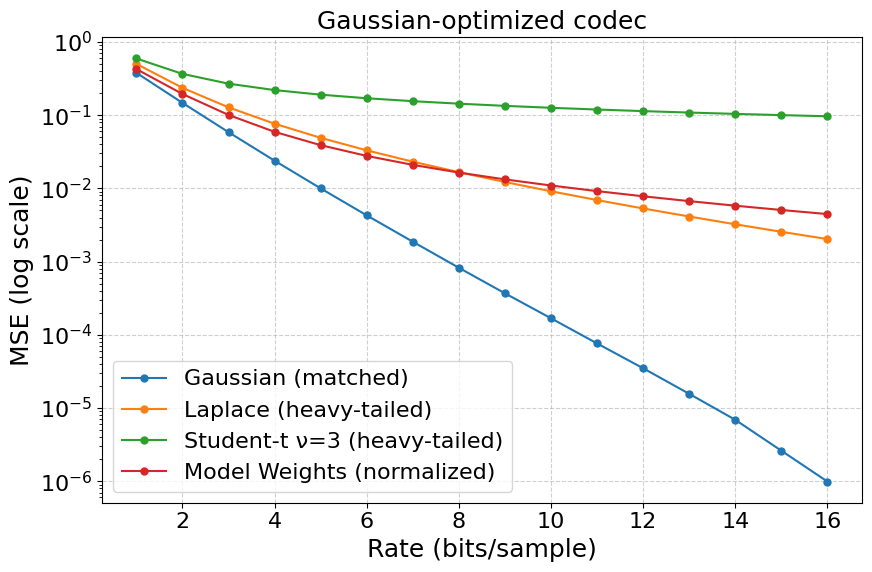

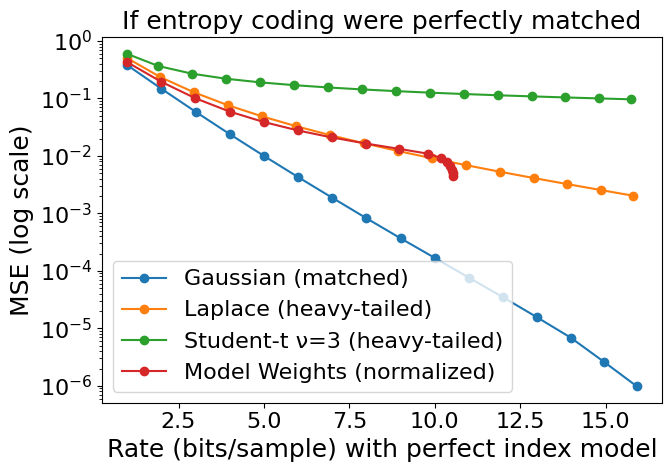

In [3]:
def sample_gauss(rng, n):
    return rng.standard_normal(n)

def sample_laplace(rng, n):
    # Laplace with b=1/sqrt(2) -> var=1
    b = 1/np.sqrt(2)
    return rng.laplace(0, b, n)

def sample_student_t(rng, n, nu=3):
    x = rng.standard_t(nu, n)
    scale = np.sqrt(nu/(nu-2))
    return x / scale

Phi = st.norm.cdf
Phi_inv = st.norm.ppf

def get_cdf_icdf(dist, nu=3):
    if dist == "gauss":
        return st.norm.cdf, st.norm.ppf
    elif dist == "laplace":
        b = 1/np.sqrt(2)
        return (lambda x: st.laplace.cdf(x, 0, b)), (lambda u: st.laplace.ppf(u, 0, b))
    elif dist == "studentt":
        scale = np.sqrt(nu/(nu-2))
        return (lambda x: st.t.cdf(x*scale, df=nu)), (lambda u: st.t.ppf(u, df=nu)/scale)
    else:
        raise ValueError(dist)

def gauss_codec_quantize(x, B):
    L = 1 << B
    u = Phi(x)
    k = np.floor(u * L).astype(int)
    k = np.clip(k, 0, L-1)
    uhat = (k + 0.5) / L
    xhat = Phi_inv(uhat)
    return k, xhat, L

def codec_quantize_with(cdf, icdf, x, B):
    L = 1 << B
    u = np.clip(cdf(x), 1e-12, 1-1e-12)
    k = np.clip(np.floor(u*L).astype(int), 0, L-1)
    uhat = (k+0.5)/L
    xhat = icdf(uhat)
    return k, xhat, L

def empirical_index_probs(k, L):
    counts = np.bincount(k, minlength=L).astype(np.float64)
    p = counts / counts.sum()
    eps = 1e-12
    p = np.clip(p, eps, 1.0)
    p /= p.sum()
    return p

def rate_cross_entropy(p, q):
    eps = 1e-12
    q = np.clip(q, eps, 1.0)
    return float(-np.sum(p * np.log2(q)))

def rate_entropy(p):
    return float(-np.sum(p * np.log2(p)))

def psnr_from_mse(mse):
    return 10*np.log10(1.0/np.asarray(mse))

def main(seed=0, N=500_000, Bmin=1, Bmax=16, save_prefix="gauss_vs_heavytail", weight_np=None):
    rng = np.random.default_rng(seed)
    Bs = list(range(Bmin, Bmax+1))

    sources = {
        "Gaussian (matched)": lambda n: sample_gauss(rng, n),
        "Laplace (heavy-tailed)": lambda n: sample_laplace(rng, n),
        "Student-t ν=3 (heavy-tailed)": lambda n: sample_student_t(rng, n, 3),
    }

    # weight_np가 들어오면 weight 추가
    if weight_np is not None:
        def sample_weight(n):
            # weight에서 무작위 샘플링 (치환 허용)
            idx = rng.integers(0, len(weight_np), size=n)
            return weight_np[idx]
        sources["Model Weights (normalized)"] = sample_weight

    results = {name: {"R_cross": [], "R_opt": [], "MSE": []} for name in sources}

    for name, sampler in sources.items():
        x = sampler(N)
        for B in Bs:
            k, xhat, L = gauss_codec_quantize(x, B)
            p_idx = empirical_index_probs(k, L)
            q_idx = np.full(L, 1.0/L)
            R_cross = rate_cross_entropy(p_idx, q_idx)
            R_opt = rate_entropy(p_idx)
            mse = float(np.mean((x - xhat) ** 2))
            results[name]["R_cross"].append(R_cross)
            results[name]["R_opt"].append(R_opt)
            results[name]["MSE"].append(mse)

    # --- 이하 plotting 및 출력 부분은 동일 ---
    plt.figure(figsize=(9,6))
    for name in sources:
        R = np.array(results[name]["R_cross"])
        D = np.array(results[name]["MSE"])
        order = np.argsort(R)
        plt.plot(R[order], D[order], marker='o', label=name, ms = 5)
    plt.yscale('log')
    # plt.xlabel("Rate (bits/sample) using Gaussian index model")
    plt.xlabel("Rate (bits/sample)")
    plt.ylabel("MSE (log scale)")
    # plt.title("Gaussian-optimized codec vs heavy-tailed sources")
    plt.title("Gaussian-optimized codec")
    plt.legend()
    plt.grid(True, which='major', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    # plt.savefig(f"{save_prefix}_RD_mismatch.png", dpi=160)

    # Reference: matched entropy coding (upper bound if coder were perfect on indices)
    plt.figure(figsize=(7,5))
    for name in sources:
        R = np.array(results[name]["R_opt"])
        D = np.array(results[name]["MSE"])
        order = np.argsort(R)
        plt.plot(R[order], D[order], marker='o', label=name)
    plt.yscale('log')
    plt.xlabel("Rate (bits/sample) with perfect index model")
    plt.ylabel("MSE (log scale)")
    plt.title("If entropy coding were perfectly matched")
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"{save_prefix}_RD_matched.png", dpi=160)

    # Print a small table at B=4,8 as a quick check
    for Bpick in [4, 8]:
        i = Bs.index(Bpick)
        print(f"=== B={Bpick} bits ===")
        for name in sources:
            Rm = results[name]['R_cross'][i]
            Dm = results[name]['MSE'][i]
            print(f"{name:24s}  R_cross={Rm:6.3f}  MSE={Dm:8.5f}  PSNR={10*np.log10(1/Dm):5.2f} dB")

    return results




# ===== 사용 예시 =====
# weight_norm = (weight - weight.mean())/weight.std()
# weight_np = weight_norm.cpu().numpy()
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
results = main(weight_np=weight_np)


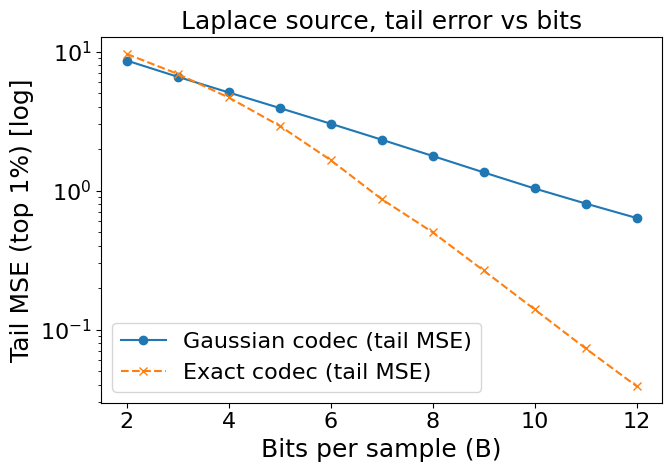

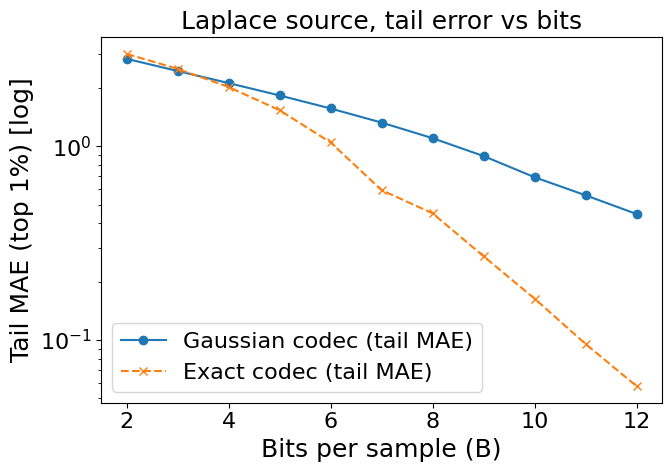

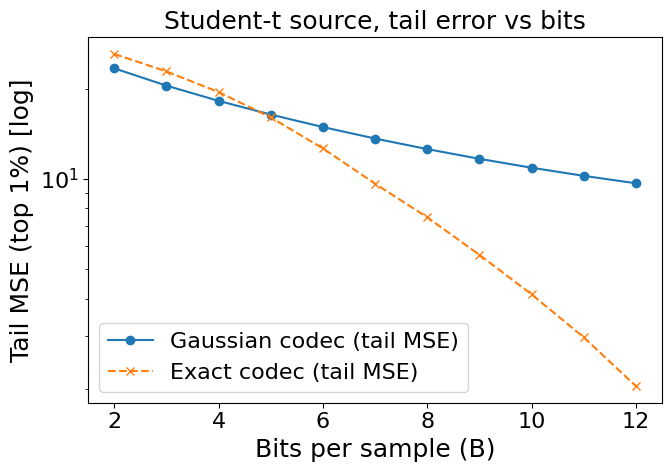

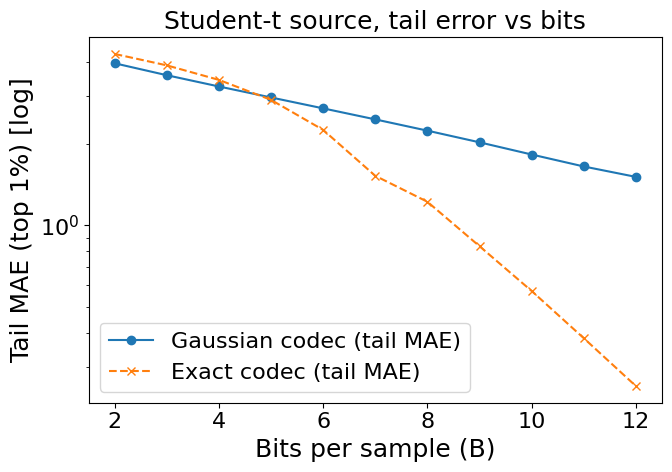

In [24]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

# ===== 소스 샘플 =====
def sample_laplace(rng, n):
    b = 1/np.sqrt(2)
    return rng.laplace(0, b, n)

def sample_student_t(rng, n, nu=3):
    x = rng.standard_t(nu, n)
    scale = np.sqrt(nu/(nu-2))
    return x / scale

# ===== CDF/ICDF =====
def get_cdf_icdf_gaussian():
    return st.norm.cdf, st.norm.ppf

def get_cdf_icdf_laplace():
    b = 1/np.sqrt(2)
    return (lambda x: st.laplace.cdf(x, 0, b)), (lambda u: st.laplace.ppf(u, 0, b))

def get_cdf_icdf_studentt(nu=3):
    scale = np.sqrt(nu/(nu-2))
    return (lambda x: st.t.cdf(x*scale, df=nu)), (lambda u: st.t.ppf(u, df=nu)/scale)

# ===== 양자화 =====
def codec_quantize(x, B, cdf, icdf):
    L = 1 << B
    u = cdf(x)
    eps = np.finfo(np.float64).eps
    u = np.clip(u, eps, 1-eps)
    k = np.floor(u * L).astype(int)
    k = np.clip(k, 0, L-1)
    uhat = (k+0.5)/L
    uhat = np.clip(uhat, eps, 1-eps)
    xhat = icdf(uhat)
    return xhat

# ===== tail 오차 계산 =====
def tail_error(x, xhat, frac=0.01):
    e = x - xhat
    thr = np.quantile(np.abs(x), 1-frac)
    mask = np.abs(x) >= thr
    mse_tail = np.mean(e[mask]**2)
    mae_tail = np.mean(np.abs(e[mask]))
    return mse_tail, mae_tail

# ===== 메인 루프 =====
def plot_tail_errors(source="Laplace", nu=3, N=200_000, Bmin=2, Bmax=12, frac=0.01, seed=0):
    rng = np.random.default_rng(seed)
    if source=="Laplace":
        x = sample_laplace(rng, N)
        cdf_exact, icdf_exact = get_cdf_icdf_laplace()
    elif source=="Student-t":
        x = sample_student_t(rng, N, nu=nu)
        cdf_exact, icdf_exact = get_cdf_icdf_studentt(nu)
    else:
        raise ValueError("지원하지 않는 source")

    cdf_gauss, icdf_gauss = get_cdf_icdf_gaussian()

    Bs = range(Bmin, Bmax+1)
    tail_mse_g, tail_mae_g = [], []
    tail_mse_e, tail_mae_e = [], []

    for B in Bs:
        xhat_g = codec_quantize(x, B, cdf_gauss, icdf_gauss)
        xhat_e = codec_quantize(x, B, cdf_exact, icdf_exact)

        mse_g, mae_g = tail_error(x, xhat_g, frac)
        mse_e, mae_e = tail_error(x, xhat_e, frac)

        tail_mse_g.append(mse_g)
        tail_mae_g.append(mae_g)
        tail_mse_e.append(mse_e)
        tail_mae_e.append(mae_e)

    # ===== Plot MSE =====
    plt.figure(figsize=(7,5))
    plt.plot(Bs, tail_mse_g, marker='o', label="Gaussian codec (tail MSE)")
    plt.plot(Bs, tail_mse_e, marker='x', label="Exact codec (tail MSE)", linestyle="--")
    plt.yscale("log")
    plt.xlabel("Bits per sample (B)")
    plt.ylabel(f"Tail MSE (top {int(frac*100)}%) [log]")
    plt.title(f"{source} source, tail error vs bits")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ===== Plot MAE =====
    plt.figure(figsize=(7,5))
    plt.plot(Bs, tail_mae_g, marker='o', label="Gaussian codec (tail MAE)")
    plt.plot(Bs, tail_mae_e, marker='x', label="Exact codec (tail MAE)", linestyle="--")
    plt.yscale("log")
    plt.xlabel("Bits per sample (B)")
    plt.ylabel(f"Tail MAE (top {int(frac*100)}%) [log]")
    plt.title(f"{source} source, tail error vs bits")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===== 실행 예시 =====
# Laplace 분포
plot_tail_errors(source="Laplace", N=200_000, Bmin=2, Bmax=12)

# Student-t ν=3 분포
plot_tail_errors(source="Student-t", nu=3, N=200_000, Bmin=2, Bmax=12)


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# ===== Gaussian CDF/PPF =====
def get_cdf_icdf_gaussian():
    return st.norm.cdf, st.norm.ppf

# ===== Empirical CDF/PPF (from training weights) =====
def build_empirical_cdf_icdf(train):
    train = np.asarray(train, dtype=np.float64)
    xs = np.sort(train)
    n  = xs.size
    # ECDF: F(x) ≈ rank/n  (midpoint correction)
    def cdf(x):
        x = np.asarray(x, dtype=np.float64)
        idx = np.searchsorted(xs, x, side='right')
        # midpoint: (idx-0.5)/n, 단 [0,1]로 클립
        u = (idx - 0.5) / n
        return np.clip(u, 1e-12, 1-1e-12)

    # EPPF(quantile): 선형보간
    us = (np.arange(n) + 0.5) / n  # in (0,1)
    def icdf(u):
        u = np.asarray(u, dtype=np.float64)
        u = np.clip(u, 1e-12, 1-1e-12)
        # 보간용 인덱스
        pos = np.interp(u, us, np.arange(n))
        i0 = np.floor(pos).astype(int)
        i1 = np.clip(i0 + 1, 0, n-1)
        t  = pos - i0
        return (1-t) * xs[np.clip(i0, 0, n-1)] + t * xs[i1]

    return cdf, icdf

# ===== 코덱 (CDF-컴팬딩 양자화) =====
def codec_quantize(x, B, cdf, icdf):
    L = 1 << B
    u = cdf(x)
    u = np.clip(u, 1e-12, 1-1e-12)
    k = np.floor(u * L).astype(int)
    k = np.clip(k, 0, L-1)
    uhat = (k + 0.5) / L
    uhat = np.clip(uhat, 1e-12, 1-1e-12)
    xhat = icdf(uhat)
    return xhat

def tail_error(x, xhat, frac=0.01):
    e = x - xhat
    thr = np.quantile(np.abs(x), 1-frac)
    mask = np.abs(x) >= thr
    mse_tail = float(np.mean(e[mask]**2))
    mae_tail = float(np.mean(np.abs(e[mask])))
    return mse_tail, mae_tail

# ===== 메인: weight용 Tail 에러 vs 비트 (Gaussian vs Empirical) =====
def plot_tail_errors_weights(weight_np, Bmin=2, Bmax=12, frac=0.01, seed=0, train_ratio=0.8, title_prefix="Weights"):
    rng = np.random.default_rng(seed)
    w = np.asarray(weight_np, dtype=np.float64)
    # (권장) 표준화
    w = (w - w.mean()) / w.std()

    # train/test split (ECDF는 train으로 적합, 평가는 test로)
    n = w.size
    idx = rng.permutation(n)
    ntr = int(n * train_ratio)
    w_tr, w_te = w[idx[:ntr]], w[idx[ntr:]]

    # 코덱들
    cdf_g,  icdf_g  = get_cdf_icdf_gaussian()
    cdf_e,  icdf_e  = build_empirical_cdf_icdf(w_tr)

    Bs = list(range(Bmin, Bmax+1))
    mse_g, mae_g, mse_e, mae_e = [], [], [], []

    for B in Bs:
        xhat_g = codec_quantize(w_te, B, cdf_g, icdf_g)
        xhat_e = codec_quantize(w_te, B, cdf_e, icdf_e)
        mg, ag = tail_error(w_te, xhat_g, frac)
        me, ae = tail_error(w_te, xhat_e, frac)
        mse_g.append(mg); mae_g.append(ag)
        mse_e.append(me); mae_e.append(ae)

    # --- Plot Tail MSE ---
    plt.figure(figsize=(7,5))
    plt.plot(Bs, mse_g, marker='o', label="Gaussian codec (tail MSE)")
    plt.plot(Bs, mse_e, marker='x', linestyle='--', label="Empirical-CDF codec (tail MSE)")
    # plt.yscale('log')
    plt.xlabel("Bits per sample (B)")
    plt.ylabel(f"Tail MSE (top {int(frac*100)}%) [log]")
    plt.title(f"{title_prefix}: Tail MSE vs Bits")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Tail MAE ---
    plt.figure(figsize=(7,5))
    plt.plot(Bs, mae_g, marker='o', label="Gaussian codec (tail MAE)")
    plt.plot(Bs, mae_e, marker='x', linestyle='--', label="Empirical-CDF codec (tail MAE)")
    plt.yscale('log')
    plt.xlabel("Bits per sample (B)")
    plt.ylabel(f"Tail MAE (top {int(frac*100)}%) [log]")
    plt.title(f"{title_prefix}: Tail MAE vs Bits")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===== 사용 예시 =====
# 1) torch에서 weight 모은 뒤
# weight = torch.cat(collected_weights).cpu().numpy()
# 2) 바로 호출
w_small = sample_quantile_balanced(weight_np, n_sample=500_000, n_bins=100, seed=42)

plot_tail_errors_weights(w_small, Bmin=2, Bmax=12, frac=0.01, seed=0, title_prefix="Llama3-8B Weights")


NameError: name 'sample_quantile_balanced' is not defined

In [ ]:
import numpy as np

def sample_uniform(weight_np: np.ndarray, n_sample: int, seed: int = 0):
    """무작위 비복원 샘플링(전체에서 균일)."""
    rng = np.random.default_rng(seed)
    n = weight_np.size
    if n_sample >= n: 
        return weight_np
    idx = rng.choice(n, size=n_sample, replace=False)
    return weight_np[idx]

def sample_quantile_balanced(weight_np: np.ndarray, n_sample: int, n_bins: int = 100, seed: int = 0):
    """
    분위(quantile)별로 동일 비율을 뽑아 꼬리 보존.
    예) n_bins=100이면 각 1% 구간에서 동일 개수 샘플.
    """
    rng = np.random.default_rng(seed)
    n = weight_np.size
    if n_sample >= n: 
        return weight_np

    # 정규화(선택): 분포 모양을 안정화
    w = (weight_np - weight_np.mean()) / weight_np.std()

    # 분위 경계
    qs = np.linspace(0, 1, n_bins + 1)
    edges = np.quantile(w, qs)

    per_bin = max(1, n_sample // n_bins)
    samples = []
    for b in range(n_bins):
        lo, hi = edges[b], edges[b+1]
        # 마지막 bin은 우측 포함
        if b < n_bins - 1:
            mask = (w >= lo) & (w < hi)
        else:
            mask = (w >= lo) & (w <= hi)

        idxs = np.flatnonzero(mask)
        if idxs.size == 0:
            continue
        take = min(per_bin, idxs.size)
        pick = rng.choice(idxs, size=take, replace=False)
        samples.append(weight_np[pick])  # 원래 스케일 유지

    samp = np.concatenate(samples) if samples else np.array([], dtype=weight_np.dtype)

    # 목표 개수에 못 미치면 남은 부분은 균일추출로 채움(중복 방지)
    if samp.size < n_sample:
        # 이미 뽑은 인덱스 제외하고 보충
        # 간단히 전체에서 추가 추출(조금 중복 허용해도 되면 replace=True로)
        remain = n_sample - samp.size
        add = sample_uniform(weight_np, remain, seed+1)
        samp = np.concatenate([samp, add])

    # 정확히 n_sample로 맞춤
    if samp.size > n_sample:
        samp = samp[rng.choice(samp.size, size=n_sample, replace=False)]
    return samp


In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

# ===== 기본 CDF/ICDF =====
def get_cdf_icdf_gaussian():
    return st.norm.cdf, st.norm.ppf

def get_cdf_icdf_laplace():
    b = 1/np.sqrt(2)  # var=1
    return (lambda x: st.laplace.cdf(x, 0, b)), (lambda u: st.laplace.ppf(u, 0, b))

# ===== 소스 =====
def sample_laplace(rng, n):
    b = 1/np.sqrt(2)
    return rng.laplace(0, b, n)

# ===== 코덱(균등양자화 in u) =====
def codec_quantize(x, B, cdf, icdf):
    L = 1 << B
    u = cdf(x)
    eps = np.finfo(np.float64).eps
    u = np.clip(u, eps, 1-eps)
    k = np.floor(u * L).astype(np.int64)
    k = np.clip(k, 0, L-1)
    uhat = (k + 0.5) / L
    uhat = np.clip(uhat, eps, 1-eps)
    xhat = icdf(uhat)
    return xhat

# ===== Tail 오차 =====
def tail_error(x, xhat, frac=0.01):
    e = x - xhat
    thr = np.quantile(np.abs(x), 1-frac)
    m = (np.abs(x) >= thr)
    return float(np.mean(e[m]**2)), float(np.mean(np.abs(e[m])))

# ===== 메인 함수 =====
def plot_tail_errors_three(weight_np,
                           N_laplace=200_000,  # 라플라스 소스 샘플 수
                           Bmin=2, Bmax=12, tail_frac=0.01, seed=0,
                           weight_subsample=500_000, title_prefix="Tail error vs Bits"):
    rng = np.random.default_rng(seed)

    # --- 소스 준비 ---
    # Laplace (unit variance)
    x_lap = sample_laplace(rng, N_laplace)

    # Weights (정규화 + 필요시 샘플 축소)
    w = np.asarray(weight_np, dtype=np.float64)
    w = (w - w.mean()) / w.std()
    if weight_subsample is not None and weight_subsample < w.size:
        idx = rng.choice(w.size, size=weight_subsample, replace=False)
        w = w[idx]

    # --- 코덱 ---
    cdf_g, icdf_g = get_cdf_icdf_gaussian()
    cdf_l, icdf_l = get_cdf_icdf_laplace()

    Bs = list(range(Bmin, Bmax+1))

    # 결과 컨테이너
    res = {
        "GaussCodec×LaplaceSrc": {"MSE": [], "MAE": []},
        "GaussCodec×WeightSrc": {"MSE": [], "MAE": []},
        "LaplaceCodec×LaplaceSrc": {"MSE": [], "MAE": []},
    }

    # --- 비트 루프 ---
    for B in Bs:
        # 1) 가우시안 코덱 × 라플라스 소스
        xhat_g_lap = codec_quantize(x_lap, B, cdf_g, icdf_g)
        mse, mae = tail_error(x_lap, xhat_g_lap, tail_frac)
        res["GaussCodec×LaplaceSrc"]["MSE"].append(mse)
        res["GaussCodec×LaplaceSrc"]["MAE"].append(mae)

        # 2) 가우시안 코덱 × 웨이트 소스
        what_g = codec_quantize(w, B, cdf_g, icdf_g)
        mse, mae = tail_error(w, what_g, tail_frac)
        res["GaussCodec×WeightSrc"]["MSE"].append(mse)
        res["GaussCodec×WeightSrc"]["MAE"].append(mae)

        # 3) 라플라스 코덱 × 라플라스 소스 (exact)
        xhat_l_lap = codec_quantize(x_lap, B, cdf_l, icdf_l)
        mse, mae = tail_error(x_lap, xhat_l_lap, tail_frac)
        res["LaplaceCodec×LaplaceSrc"]["MSE"].append(mse)
        res["LaplaceCodec×LaplaceSrc"]["MAE"].append(mae)

    # --- 플롯: Tail MSE ---
    plt.figure(figsize=(7,5))
    for k, v in res.items():
        plt.plot(Bs, v["MSE"], marker='o', label=k)
    plt.yscale("log")
    plt.xlabel("Bits per sample (B)")
    plt.ylabel(f"Tail MSE (top {int(tail_frac*100)}%) [log]")
    plt.title(f"{title_prefix} — Tail MSE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 플롯: Tail MAE ---
    plt.figure(figsize=(7,5))
    for k, v in res.items():
        plt.plot(Bs, v["MAE"], marker='o', label=k)
    plt.yscale("log")
    plt.xlabel("Bits per sample (B)")
    plt.ylabel(f"Tail MAE (top {int(tail_frac*100)}%) [log]")
    plt.title(f"{title_prefix} — Tail MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return Bs, res

# ===== 사용 예시 =====
# weight_np = ...  # (torch에서 모은 뒤 .cpu().numpy())
Bs, res = plot_tail_errors_three(weight_np, N_laplace=200_000, Bmin=2, Bmax=12, tail_frac=0.01, weight_subsample=500_000)


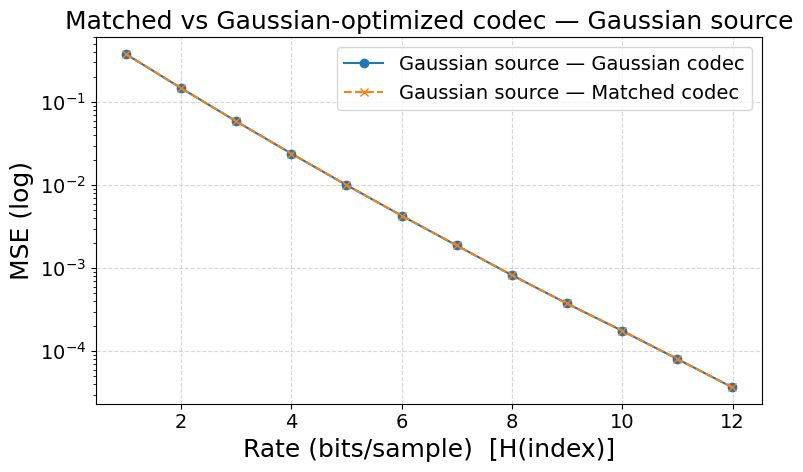

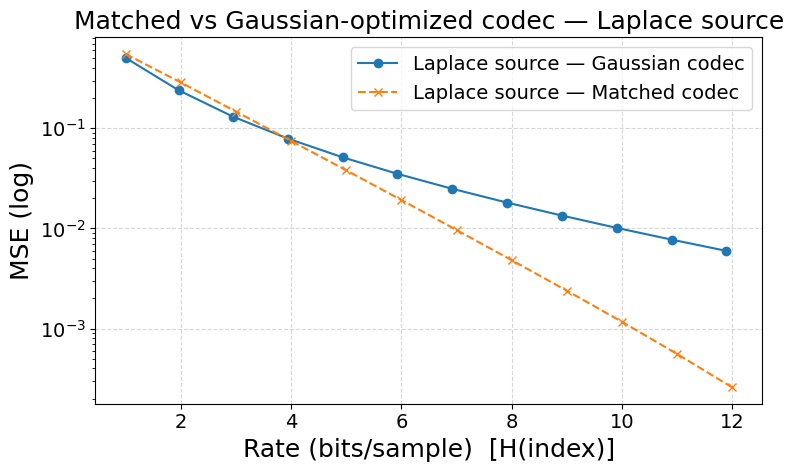

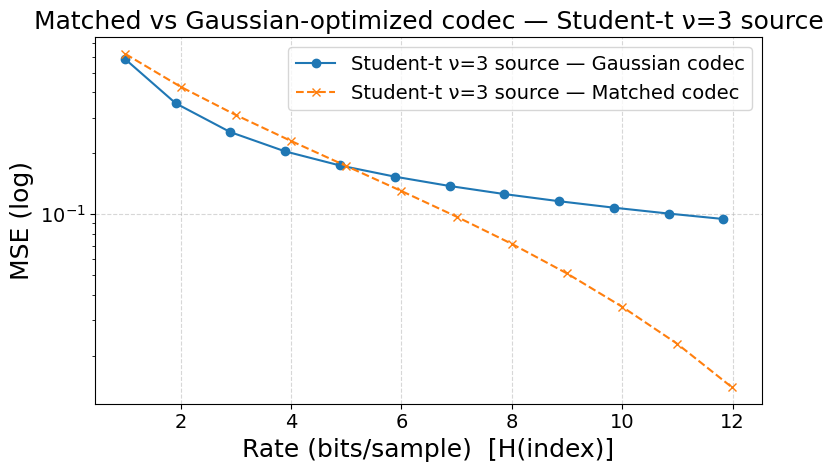

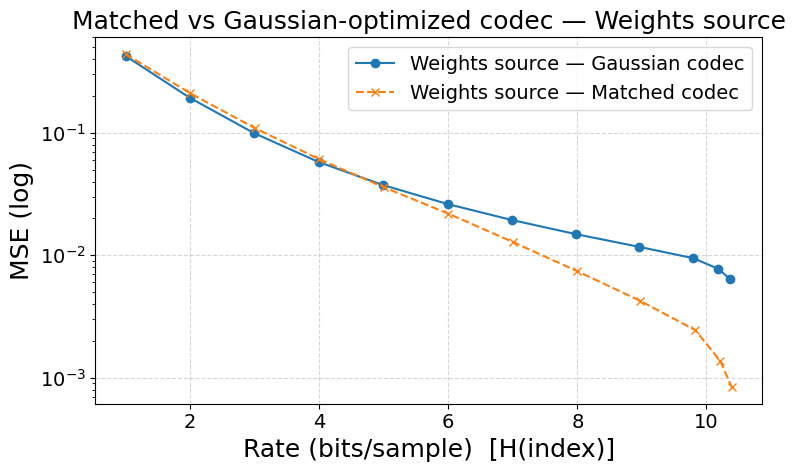

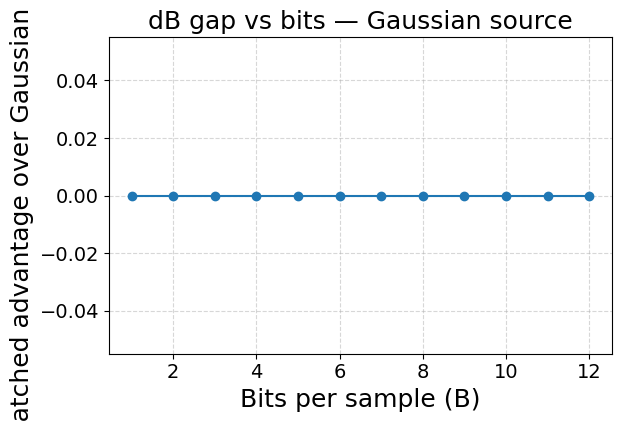

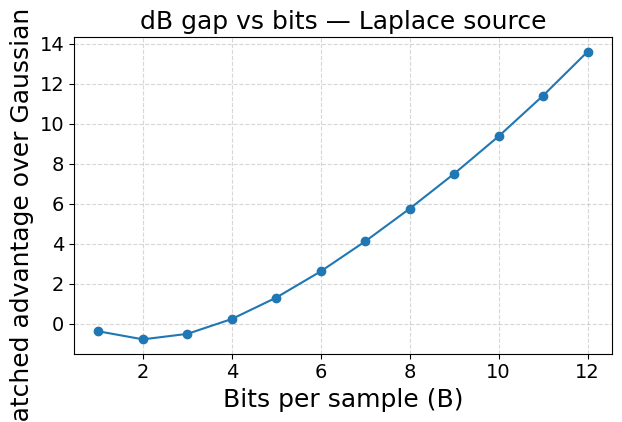

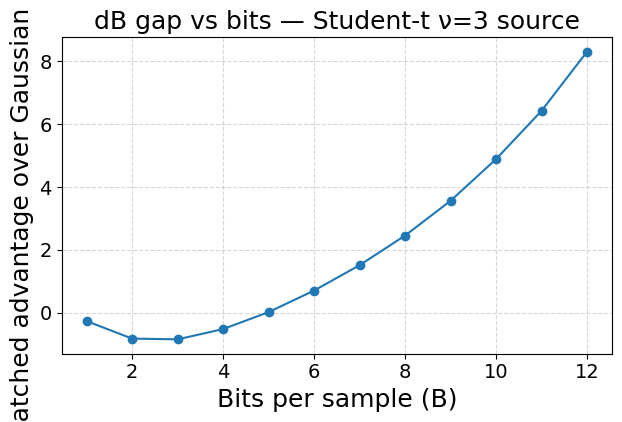

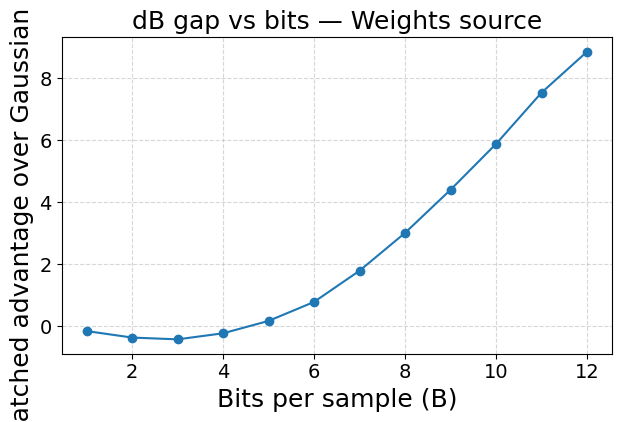

In [3]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

# ---------- 소스 샘플 ----------
def sample_gauss(rng, n):   return rng.standard_normal(n)
def sample_laplace(rng, n):
    b = 1/np.sqrt(2)        # var=1
    return rng.laplace(0, b, n)
def sample_student_t(rng, n, nu=3):
    x = rng.standard_t(nu, n)
    scale = np.sqrt(nu/(nu-2))
    return x/scale

# ---------- 분포별 CDF/PPF ----------
def get_cdf_icdf(dist, nu=3):
    if dist == "gauss":
        return st.norm.cdf, st.norm.ppf
    elif dist == "laplace":
        b = 1/np.sqrt(2)
        return (lambda x: st.laplace.cdf(x, 0, b)), (lambda u: st.laplace.ppf(u, 0, b))
    elif dist == "studentt":
        scale = np.sqrt(nu/(nu-2))
        return (lambda x: st.t.cdf(x*scale, df=nu)), (lambda u: st.t.ppf(u, df=nu)/scale)
    else:
        raise ValueError(dist)

# ---------- Empirical CDF/PPF (빠른 K-노드 근사; weights용 matched) ----------
def build_cdf_icdf_knots(train, K=4096, dtype=np.float32):
    x = np.asarray(train, dtype=dtype)
    us_knots = np.linspace(0.0 + 0.5/K, 1.0 - 0.5/K, K, dtype=np.float64)
    xs_knots = np.quantile(x.astype(np.float64), us_knots).astype(dtype)
    grid = np.arange(K, dtype=np.float64)

    def cdf(arr):
        arr = np.asarray(arr, dtype=dtype)
        pos = np.interp(arr.astype(np.float64), xs_knots.astype(np.float64), grid)
        u = (pos + 0.5)/K
        return np.clip(u, 1e-12, 1-1e-12).astype(np.float64)

    def icdf(u):
        u = np.asarray(u, dtype=np.float64)
        u = np.clip(u, 1e-12, 1-1e-12)
        pos = u*K - 0.5
        xhat = np.interp(pos, grid, xs_knots.astype(np.float64))
        return xhat.astype(dtype)

    return cdf, icdf

# ---------- 공통 유틸 ----------
def quantize_with_cdf(x, B, cdf, icdf):
    L = 1 << B
    u = np.clip(cdf(x), 1e-12, 1-1e-12)
    k = np.clip(np.floor(u*L).astype(np.int64), 0, L-1)
    uhat = (k + 0.5)/L
    xhat = icdf(uhat)
    return k, xhat, L

def p_from_indices(k, L):
    cnt = np.bincount(k, minlength=L).astype(np.float64)
    p = cnt / cnt.sum()
    p = np.clip(p, 1e-12, 1.0); p /= p.sum()
    return p

def H_bits(p):           return float(-(p*np.log2(p)).sum())
def cross_H_bits(p, q):  return float(-(p*np.log2(np.clip(q,1e-12,1))).sum())

# ---------- 한 소스에 대해: 미스매치(가우시안 코덱) vs 매칭(정확/empirical) ----------
def compare_one_source(x, Bs, matched_cdf, matched_icdf, label):
    # 미스매치 코덱(가우시안 CDF) 준비
    cg, ig = get_cdf_icdf("gauss")

    R_mis, D_mis = [], []
    R_mat, D_mat = [], []

    for B in Bs:
        # 미스매치(가우시안 코덱)
        k_g, xhat_g, L = quantize_with_cdf(x, B, cg, ig)
        p_g = p_from_indices(k_g, L)
        # 엔트로피 모델을 '정확히' 쓰면 필요한 비트는 H(p_g); (가우시안 모델로 부호화하면 cross-entropy는 B)
        R_mis.append(H_bits(p_g))      # "달성 가능한 최저 비트"로 비교
        D_mis.append(float(np.mean((x - xhat_g)**2)))

        # 매칭(정확/empirical 코덱)
        k_m, xhat_m, Lm = quantize_with_cdf(x, B, matched_cdf, matched_icdf)
        p_m = p_from_indices(k_m, Lm)
        R_mat.append(H_bits(p_m))
        D_mat.append(float(np.mean((x - xhat_m)**2)))

    return {
        "label": label,
        "B": Bs,
        "R_mismatch": np.array(R_mis),
        "D_mismatch": np.array(D_mis),
        "R_matched":  np.array(R_mat),
        "D_matched":  np.array(D_mat),
    }

# ---------- 메인: 세 소스 비교 (Gaussian/Laplace/Student-t, +선택: weights) ----------
def main(seed=0, N=400_000, Bmin=1, Bmax=12, weight_np=None, weight_subsample=200_000):
    rng = np.random.default_rng(seed)
    Bs = list(range(Bmin, Bmax+1))

    # 소스 샘플
    xG = sample_gauss(rng, N)
    xL = sample_laplace(rng, N)
    xT = sample_student_t(rng, N, 3)

    # 매칭 코덱
    cG, iG = get_cdf_icdf("gauss")
    cL, iL = get_cdf_icdf("laplace")
    cT, iT = get_cdf_icdf("studentt")

    out = []
    out.append(compare_one_source(xG, Bs, cG, iG, "Gaussian source"))
    out.append(compare_one_source(xL, Bs, cL, iL, "Laplace source"))
    out.append(compare_one_source(xT, Bs, cT, iT, "Student-t ν=3 source"))

    if weight_np is not None:
        w = weight_np
        if weight_subsample is not None and weight_subsample < w.size:
            idx = rng.integers(0, len(w), size=weight_subsample)
            # idx = rng.choice(w.size, size=weight_subsample, replace=False)
            w = w[idx]
        # empirical matched 코덱
        cE, iE = build_cdf_icdf_knots(w, K=4096, dtype=np.float32)
        out.append(compare_one_source(w, Bs, cE, iE, "Weights source"))

    # ---- 플롯: 각 소스별로 미스매치 vs 매칭 (같은 그림) ----
    for res in out:
        plt.figure(figsize=(8,5))
        # 미스매치(가우시안 코덱)
        idx = np.argsort(res["R_mismatch"])
        plt.plot(res["R_mismatch"][idx], res["D_mismatch"][idx], marker='o', linestyle='-',
                 label=f"{res['label']} — Gaussian codec")
        # 매칭(정확/empirical 코덱)
        idm = np.argsort(res["R_matched"])
        plt.plot(res["R_matched"][idm], res["D_matched"][idm], marker='x', linestyle='--',
                 label=f"{res['label']} — Matched codec")
        plt.yscale('log')
        plt.xlabel("Rate (bits/sample)  [H(index)]")
        plt.ylabel("MSE (log)")
        plt.title(f"Matched vs Gaussian-optimized codec — {res['label']}")
        plt.grid(True, ls='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ---- 덧: dB 격차(미스매치 대비 매칭) 시각화 ----
    for res in out:
        # 같은 B에서 비교하려면 B축 기준으로 계산하는 게 직관적이나,
        # 여기선 R축(H(index))에서 보이도록 보정 없이 dB 차만 표시
        # (고레이트에선 거의 상수 dB 차로 수렴)
        # R을 단조증가 배열로 보간해도 됨. 간단히 같은 길이 인덱스 사용.
        Dg = res["D_mismatch"]
        Dm = res["D_matched"]
        # 길이 맞추기(간단히 앞쪽 min 길이만)
        m = min(len(Dg), len(Dm))
        gap_db = 10*np.log10(Dg[:m] / Dm[:m] + 1e-30)
        plt.figure(figsize=(6.5,4.5))
        plt.plot(res["B"][:m], gap_db, marker='o')
        plt.xlabel("Bits per sample (B)")
        plt.ylabel("Matched advantage over Gaussian (dB)")
        plt.title(f"dB gap vs bits — {res['label']}")
        plt.grid(True, ls='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return out

# ===== 사용 예시 =====
# weight_norm = (weight - weight.mean())/ (weight.std()+1e-12)
# weight_np = weight_norm.cpu().numpy()
plt.rcParams.update({
    'font.size': 16, 'axes.titlesize': 18, 'axes.labelsize': 18,
    'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14,
})
# weights 없으면 weight_np=None로 호출
out = main(weight_np=weight_np, N=200_000, Bmin=1, Bmax=12)
